In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class GE_Thyroid_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        image_type = self.df["image_type"][idx]

        if image_type == "train":
            from_folder = "../ge_data/train"
        else:
            from_folder = "../ge_data/test"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, mask_name, image_type

In [47]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = train_augmentation, image_size = image_size)
# train_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = GE_Thyroid_Dataset("../ge_data/test_csv_for_finetune_all.csv", transform = test_augmentation, image_size = image_size)
# test_dataset = GE_Thyroid_Dataset("../ge_data/train_csv_for_finetune(0.3).csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, mask_name, image_type = next(iter(train_dataloader))

In [48]:
image.shape

torch.Size([115, 1, 128, 128])

In [49]:
print(len(train_dataset), len(test_dataset))

169 112


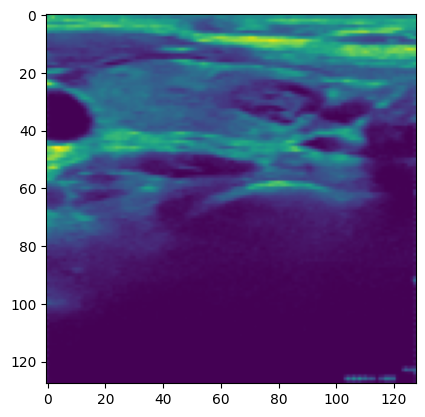

In [50]:
plt.imshow(image[18][0])

In [51]:

# inference_name = "hybrid_v3_baseline"

# model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
# checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# loss_fn = StructureLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# lr = 0.01
# model.to("cuda")
# image = image.to("cuda")
# mask = mask.to("cuda")
# for epoch in range(200):
#     outputs = model(image)
        
#     output = outputs[:, 0:1, :, :]
    
    
#     loss = loss_fn(output, mask)

#     IOU = IOU_score(output, mask)

#     dice_loss = DiceLoss()
#     DICE = 1 - dice_loss(output, mask)

    
#     # Backward and optimize
#     optimizer.zero_grad()   # clear previous gradients
#     loss.backward()         # compute gradients
#     optimizer.step()        # update weights
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, IOU: {IOU.item():.4f}, DICE: {DICE.item()}")

In [52]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        # count+=1
        # if count==5:
        #     break
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    for image, mask, mask_name, image_type in tqdm(dataloader):
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
    return total_loss/len(dataloader), total_IOU/len(dataloader), total_DICE/len(dataloader)


    

In [53]:

inference_name = "hybrid_v3_baseline"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [54]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [55]:

epochs = 500
lr = 0.005
loss_fn = StructureLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [56]:

project = "thyroid_ge_finetune"
name = "hybrid_model_baseline(0.3)_freeze_encoder_wo_zeromask_aug_translate_scale"
# name = "test"
wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [57]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/{name}"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
if not os.path.exists(folder):
    os.mkdir(folder)
torch.save(checkpoint, f"models/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 1.6320512890815735, train IOU : 0.35281914472579956, train DICE : 0.5444077551364899


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 1.546136498451233, val IOU : 0.07376700639724731, val DICE : 0.10348880290985107
epoch : 1


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.9579287767410278, train IOU : 0.2568846419453621, train DICE : 0.3621269166469574


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


val loss : 0.9965928792953491, val IOU : 0.34329766035079956, val DICE : 0.43810808658599854
epoch : 2


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.6579580008983612, train IOU : 0.4669772684574127, train DICE : 0.5733382105827332


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


val loss : 0.5007240772247314, val IOU : 0.677395224571228, val DICE : 0.7739505767822266
epoch : 3


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.5591709315776825, train IOU : 0.546795517206192, train DICE : 0.6613469123840332


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.4253755211830139, val IOU : 0.7103579640388489, val DICE : 0.8059931397438049
epoch : 4


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.5607810020446777, train IOU : 0.5378970205783844, train DICE : 0.6793602705001831


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.4261114299297333, val IOU : 0.6844952702522278, val DICE : 0.7894405722618103
epoch : 5


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.5173002928495407, train IOU : 0.5428045690059662, train DICE : 0.6902166604995728


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.42664116621017456, val IOU : 0.6770821809768677, val DICE : 0.782283365726471
epoch : 6


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.56705641746521, train IOU : 0.5054493397474289, train DICE : 0.6604970097541809


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3996252715587616, val IOU : 0.7045963406562805, val DICE : 0.8017655611038208
epoch : 7


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.5446867942810059, train IOU : 0.5324320495128632, train DICE : 0.6905740797519684


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3900473415851593, val IOU : 0.7164550423622131, val DICE : 0.8097103834152222
epoch : 8


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.5657983720302582, train IOU : 0.5076240599155426, train DICE : 0.6339947879314423


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.39439883828163147, val IOU : 0.6998924016952515, val DICE : 0.7921791672706604
epoch : 9


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.5080503970384598, train IOU : 0.5783616304397583, train DICE : 0.6872707009315491


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.4040209949016571, val IOU : 0.6856359839439392, val DICE : 0.7775044441223145
epoch : 10


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.5008010864257812, train IOU : 0.5580879151821136, train DICE : 0.6811502873897552


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.3882262706756592, val IOU : 0.7084894180297852, val DICE : 0.7952855229377747
epoch : 11


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.49128635227680206, train IOU : 0.601030558347702, train DICE : 0.7052067518234253


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.38775548338890076, val IOU : 0.718431830406189, val DICE : 0.8018661737442017
epoch : 12


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.5395479649305344, train IOU : 0.5714268088340759, train DICE : 0.6730669736862183


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.3840622901916504, val IOU : 0.709296703338623, val DICE : 0.7877751588821411
epoch : 13


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.5275710821151733, train IOU : 0.5682553350925446, train DICE : 0.6676767468452454


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.3967031240463257, val IOU : 0.6971871852874756, val DICE : 0.7703108191490173
epoch : 14


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.5072673261165619, train IOU : 0.5386830568313599, train DICE : 0.6667783856391907


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.3761853575706482, val IOU : 0.7191945910453796, val DICE : 0.7934789061546326
epoch : 15


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.5104568004608154, train IOU : 0.5840819776058197, train DICE : 0.6976254880428314


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3830796480178833, val IOU : 0.7264166474342346, val DICE : 0.8032724261283875
epoch : 16


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.4850172996520996, train IOU : 0.5991513431072235, train DICE : 0.696519672870636


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3720391094684601, val IOU : 0.7235367894172668, val DICE : 0.7963370680809021
epoch : 17


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.46678850054740906, train IOU : 0.5934417247772217, train DICE : 0.7230815589427948


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.38285085558891296, val IOU : 0.7094096541404724, val DICE : 0.7790977358818054
epoch : 18


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.5236254632472992, train IOU : 0.5627685487270355, train DICE : 0.6868684887886047


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.37838488817214966, val IOU : 0.7133470177650452, val DICE : 0.7835053205490112
epoch : 19


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.47992976009845734, train IOU : 0.5672067999839783, train DICE : 0.6929792165756226


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.36715176701545715, val IOU : 0.7310158014297485, val DICE : 0.8033220171928406
epoch : 20


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.490074098110199, train IOU : 0.5865627527236938, train DICE : 0.7071333527565002


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.37181583046913147, val IOU : 0.7326703071594238, val DICE : 0.8076451420783997
epoch : 21


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.5170303583145142, train IOU : 0.560924619436264, train DICE : 0.6929733157157898


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.36669468879699707, val IOU : 0.731492280960083, val DICE : 0.7991600632667542
epoch : 22


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.463865265250206, train IOU : 0.603259265422821, train DICE : 0.7187813818454742


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3718251883983612, val IOU : 0.7288814187049866, val DICE : 0.7922605872154236
epoch : 23


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.5014552623033524, train IOU : 0.5714771747589111, train DICE : 0.6739144027233124


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.37601348757743835, val IOU : 0.7335323691368103, val DICE : 0.7991852164268494
epoch : 24


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.4399217218160629, train IOU : 0.6201554238796234, train DICE : 0.7238316535949707


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3975130021572113, val IOU : 0.724346935749054, val DICE : 0.800408124923706
epoch : 25


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.4744477868080139, train IOU : 0.5955785810947418, train DICE : 0.720130205154419


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.35010474920272827, val IOU : 0.7456905245780945, val DICE : 0.8171371221542358
epoch : 26


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.42491716146469116, train IOU : 0.6318834722042084, train DICE : 0.7373893857002258


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.34993478655815125, val IOU : 0.7434228658676147, val DICE : 0.8107994198799133
epoch : 27


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.4579849988222122, train IOU : 0.6116085946559906, train DICE : 0.7270072102546692


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.35934746265411377, val IOU : 0.7428466081619263, val DICE : 0.8084880709648132
epoch : 28


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.42724137008190155, train IOU : 0.6297167241573334, train DICE : 0.73326575756073


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3761894106864929, val IOU : 0.7377461194992065, val DICE : 0.8043667078018188
epoch : 29


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.4275282472372055, train IOU : 0.6384907960891724, train DICE : 0.7481298446655273


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3903616666793823, val IOU : 0.7297529578208923, val DICE : 0.7998929023742676
epoch : 30


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.46369847655296326, train IOU : 0.6082150042057037, train DICE : 0.7305151224136353


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3807261288166046, val IOU : 0.7331094145774841, val DICE : 0.7978779077529907
epoch : 31


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.4146832078695297, train IOU : 0.6065223813056946, train DICE : 0.7331827580928802


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.37082210183143616, val IOU : 0.7360811233520508, val DICE : 0.802646815776825
epoch : 32


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.44835078716278076, train IOU : 0.6292069256305695, train DICE : 0.7372812628746033


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.36426252126693726, val IOU : 0.7394017577171326, val DICE : 0.8134557008743286
epoch : 33


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.39731867611408234, train IOU : 0.6506240367889404, train DICE : 0.7605563104152679


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.35932278633117676, val IOU : 0.740333616733551, val DICE : 0.8181483149528503
epoch : 34


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.4363180249929428, train IOU : 0.6130596101284027, train DICE : 0.7417364418506622


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.36065322160720825, val IOU : 0.7390601634979248, val DICE : 0.8166460394859314
epoch : 35


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.4198991060256958, train IOU : 0.6271755695343018, train DICE : 0.7500412166118622


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3677026331424713, val IOU : 0.7345412969589233, val DICE : 0.8066310286521912
epoch : 36


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.4117998480796814, train IOU : 0.6343138813972473, train DICE : 0.7533089816570282


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.37474897503852844, val IOU : 0.7303964495658875, val DICE : 0.799896776676178
epoch : 37


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.4118085205554962, train IOU : 0.6397219598293304, train DICE : 0.7470788061618805


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3759785294532776, val IOU : 0.7344193458557129, val DICE : 0.806063711643219
epoch : 38


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.41281096637248993, train IOU : 0.6421018540859222, train DICE : 0.7602739930152893


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3716447949409485, val IOU : 0.7378721237182617, val DICE : 0.8129041790962219
epoch : 39


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.3877721130847931, train IOU : 0.6601766645908356, train DICE : 0.7631852924823761


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.35869401693344116, val IOU : 0.7436020374298096, val DICE : 0.8171548247337341
epoch : 40


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.40244075655937195, train IOU : 0.6524983644485474, train DICE : 0.7581180930137634


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3610725998878479, val IOU : 0.7423129081726074, val DICE : 0.8137452602386475
epoch : 41


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.40452876687049866, train IOU : 0.6422969400882721, train DICE : 0.7429837286472321


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.36884623765945435, val IOU : 0.7380052208900452, val DICE : 0.8097867965698242
epoch : 42


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.3775409460067749, train IOU : 0.6593461334705353, train DICE : 0.776461660861969


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.37945517897605896, val IOU : 0.7335871458053589, val DICE : 0.81246417760849
epoch : 43


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.37260866165161133, train IOU : 0.6728493869304657, train DICE : 0.7833252847194672


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3819650411605835, val IOU : 0.7308234572410583, val DICE : 0.8180510401725769
epoch : 44


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.44862933456897736, train IOU : 0.6245992183685303, train DICE : 0.7572140395641327


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.358999639749527, val IOU : 0.7412520051002502, val DICE : 0.8192595839500427
epoch : 45


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.396339476108551, train IOU : 0.6507470607757568, train DICE : 0.7543791830539703


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3590640127658844, val IOU : 0.7360297441482544, val DICE : 0.8096333146095276
epoch : 46


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.4367130845785141, train IOU : 0.5976381003856659, train DICE : 0.7364439964294434


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3653123378753662, val IOU : 0.7400001883506775, val DICE : 0.8180047273635864
epoch : 47


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.3723647892475128, train IOU : 0.6812552213668823, train DICE : 0.781586080789566


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.39589691162109375, val IOU : 0.7259315252304077, val DICE : 0.81342613697052
epoch : 48


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.4444319009780884, train IOU : 0.6292161345481873, train DICE : 0.7341309189796448


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.38037800788879395, val IOU : 0.7339140772819519, val DICE : 0.815995991230011
epoch : 49


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.38566645979881287, train IOU : 0.6829935610294342, train DICE : 0.775324136018753


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.366326242685318, val IOU : 0.7358384728431702, val DICE : 0.8091538548469543
epoch : 50


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.3942854702472687, train IOU : 0.634185403585434, train DICE : 0.750848650932312


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.36638060212135315, val IOU : 0.7332289218902588, val DICE : 0.804289698600769
epoch : 51


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.37647223472595215, train IOU : 0.6468954384326935, train DICE : 0.7565036416053772


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.381247878074646, val IOU : 0.7291536927223206, val DICE : 0.8065382242202759
epoch : 52


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.39752428233623505, train IOU : 0.6778930425643921, train DICE : 0.7626796960830688


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.4092872142791748, val IOU : 0.7124682068824768, val DICE : 0.7958024740219116
epoch : 53


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.42168381810188293, train IOU : 0.6608406603336334, train DICE : 0.7579546272754669


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3771189749240875, val IOU : 0.7283302545547485, val DICE : 0.8072659969329834
epoch : 54


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.3660755008459091, train IOU : 0.6747113466262817, train DICE : 0.7760704159736633


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3561171591281891, val IOU : 0.737217128276825, val DICE : 0.8128281235694885
epoch : 55


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.39452195167541504, train IOU : 0.6439180672168732, train DICE : 0.7553708255290985


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3501526415348053, val IOU : 0.7423728704452515, val DICE : 0.8186734914779663
epoch : 56


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.37757857143878937, train IOU : 0.6563102304935455, train DICE : 0.7722650766372681


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.35983842611312866, val IOU : 0.7436369061470032, val DICE : 0.8208202123641968
epoch : 57


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.37127619981765747, train IOU : 0.6740612685680389, train DICE : 0.7813214957714081


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.3862851858139038, val IOU : 0.7301115393638611, val DICE : 0.8123564124107361
epoch : 58


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.3654957413673401, train IOU : 0.6850804686546326, train DICE : 0.7960213422775269


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.38091525435447693, val IOU : 0.733303427696228, val DICE : 0.8146333694458008
epoch : 59


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.36196401715278625, train IOU : 0.6766522228717804, train DICE : 0.7670644819736481


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.3658163249492645, val IOU : 0.7403843998908997, val DICE : 0.8196264505386353
epoch : 60


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.3601628541946411, train IOU : 0.6779214143753052, train DICE : 0.78893181681633


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.35762205719947815, val IOU : 0.7418426275253296, val DICE : 0.8197374939918518
epoch : 61


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.36276975274086, train IOU : 0.6665807664394379, train DICE : 0.7856283783912659


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.36212071776390076, val IOU : 0.7377892732620239, val DICE : 0.8138183355331421
epoch : 62


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.34901435673236847, train IOU : 0.6842145919799805, train DICE : 0.785853773355484


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.37196236848831177, val IOU : 0.7339954972267151, val DICE : 0.8096612691879272
epoch : 63


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.3565976023674011, train IOU : 0.6748952269554138, train DICE : 0.7814661860466003


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


val loss : 0.38341325521469116, val IOU : 0.7296749949455261, val DICE : 0.8077735900878906
epoch : 64


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.3695906698703766, train IOU : 0.651462733745575, train DICE : 0.756207287311554


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.4113110899925232, val IOU : 0.7120526432991028, val DICE : 0.7933072447776794
epoch : 65


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.3631882518529892, train IOU : 0.6740277409553528, train DICE : 0.7697020173072815


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.4127880930900574, val IOU : 0.7107225060462952, val DICE : 0.7903397679328918
epoch : 66


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.33326496183872223, train IOU : 0.7182447910308838, train DICE : 0.8015674948692322


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.38540422916412354, val IOU : 0.7280294299125671, val DICE : 0.8045530319213867
epoch : 67


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.33022791147232056, train IOU : 0.7256815433502197, train DICE : 0.8027582466602325


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.35863450169563293, val IOU : 0.7411536574363708, val DICE : 0.818723201751709
epoch : 68


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.3559250980615616, train IOU : 0.6674229502677917, train DICE : 0.7839250266551971


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3477141559123993, val IOU : 0.7471471428871155, val DICE : 0.8256087303161621
epoch : 69


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.3358018845319748, train IOU : 0.6954026520252228, train DICE : 0.8047056198120117


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.3498600125312805, val IOU : 0.7500659823417664, val DICE : 0.8293421268463135
epoch : 70


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.32767121493816376, train IOU : 0.7228789925575256, train DICE : 0.8143891096115112


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


val loss : 0.36453065276145935, val IOU : 0.7444924712181091, val DICE : 0.8246847987174988
epoch : 71


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.3607732951641083, train IOU : 0.6900186538696289, train DICE : 0.8027620613574982


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3797227442264557, val IOU : 0.7324725985527039, val DICE : 0.8127739429473877
epoch : 72


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.3324235826730728, train IOU : 0.6847410202026367, train DICE : 0.7916461527347565


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.37492483854293823, val IOU : 0.7326093316078186, val DICE : 0.811768651008606
epoch : 73


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.33151572942733765, train IOU : 0.7058339715003967, train DICE : 0.8086500763893127


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


val loss : 0.3531680703163147, val IOU : 0.7489966750144958, val DICE : 0.8260930776596069
epoch : 74


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.3110658973455429, train IOU : 0.7244283854961395, train DICE : 0.8067424893379211


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.32996538281440735, val IOU : 0.7612895369529724, val DICE : 0.8370958566665649
epoch : 75


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.3447306305170059, train IOU : 0.7177207767963409, train DICE : 0.8114170432090759


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3254334032535553, val IOU : 0.758810818195343, val DICE : 0.8366334438323975
epoch : 76


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.35025349259376526, train IOU : 0.6809530556201935, train DICE : 0.8106730878353119


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.33655956387519836, val IOU : 0.7527353763580322, val DICE : 0.8311689496040344
epoch : 77


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.32975563406944275, train IOU : 0.6907519102096558, train DICE : 0.8088113963603973


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3681151568889618, val IOU : 0.736838698387146, val DICE : 0.8187738060951233
epoch : 78


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.3865823298692703, train IOU : 0.663916826248169, train DICE : 0.7739326357841492


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.38132554292678833, val IOU : 0.7318341732025146, val DICE : 0.8137555718421936
epoch : 79


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.31480105221271515, train IOU : 0.7085582315921783, train DICE : 0.806513786315918


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.36859092116355896, val IOU : 0.7393785119056702, val DICE : 0.8198131322860718
epoch : 80


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.35338936746120453, train IOU : 0.6890397071838379, train DICE : 0.788465827703476


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3549220860004425, val IOU : 0.7465818524360657, val DICE : 0.8229892253875732
epoch : 81


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.3368529975414276, train IOU : 0.7297990918159485, train DICE : 0.8012013733386993


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3592991828918457, val IOU : 0.7436959743499756, val DICE : 0.8189706206321716
epoch : 82


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.3481801301240921, train IOU : 0.6896005868911743, train DICE : 0.7835662662982941


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.3594845235347748, val IOU : 0.7449955344200134, val DICE : 0.822100818157196
epoch : 83


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.32770968973636627, train IOU : 0.7176553308963776, train DICE : 0.8115082681179047


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.3480510115623474, val IOU : 0.7539315223693848, val DICE : 0.8306525945663452
epoch : 84


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.35110507905483246, train IOU : 0.6829286515712738, train DICE : 0.7967617809772491


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.32955873012542725, val IOU : 0.7629033327102661, val DICE : 0.8382828235626221
epoch : 85


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.3521014153957367, train IOU : 0.700454443693161, train DICE : 0.7884879410266876


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.32280510663986206, val IOU : 0.7625241875648499, val DICE : 0.839996337890625
epoch : 86


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.3076554536819458, train IOU : 0.72544065117836, train DICE : 0.8147563338279724


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.32900470495224, val IOU : 0.7575019001960754, val DICE : 0.836441695690155
epoch : 87


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.325105220079422, train IOU : 0.6964242160320282, train DICE : 0.8067878782749176


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.3494347929954529, val IOU : 0.7491358518600464, val DICE : 0.8282536268234253
epoch : 88


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.3466200828552246, train IOU : 0.7172855138778687, train DICE : 0.8076407611370087


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


val loss : 0.37358567118644714, val IOU : 0.7328767776489258, val DICE : 0.8145961761474609
epoch : 89


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.34424878656864166, train IOU : 0.6852768659591675, train DICE : 0.7819829285144806


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.37761324644088745, val IOU : 0.7304477095603943, val DICE : 0.8123398423194885
epoch : 90


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.32219330966472626, train IOU : 0.6978176534175873, train DICE : 0.8038857877254486


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3865370750427246, val IOU : 0.7285165190696716, val DICE : 0.8130239248275757
epoch : 91


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.33524562418460846, train IOU : 0.7170675098896027, train DICE : 0.8047401607036591


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3795003592967987, val IOU : 0.7330061793327332, val DICE : 0.8162669539451599
epoch : 92


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.32685723900794983, train IOU : 0.7006541192531586, train DICE : 0.8028936982154846


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.3501824736595154, val IOU : 0.7460038661956787, val DICE : 0.8258877396583557
epoch : 93


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.3311763405799866, train IOU : 0.7045227289199829, train DICE : 0.7971009910106659


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3498402237892151, val IOU : 0.7456636428833008, val DICE : 0.8264222741127014
epoch : 94


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.29173462092876434, train IOU : 0.7508744299411774, train DICE : 0.8285693526268005


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3690284788608551, val IOU : 0.7362287044525146, val DICE : 0.8208009004592896
epoch : 95


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.31979523599147797, train IOU : 0.7266050577163696, train DICE : 0.8153003454208374


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3543541729450226, val IOU : 0.7448546290397644, val DICE : 0.8283076882362366
epoch : 96


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.33785830438137054, train IOU : 0.6833254396915436, train DICE : 0.8061972260475159


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3440018892288208, val IOU : 0.7497812509536743, val DICE : 0.8325666189193726
epoch : 97


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.311643585562706, train IOU : 0.7175666093826294, train DICE : 0.8076725900173187


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.35804620385169983, val IOU : 0.7426411509513855, val DICE : 0.8259263038635254
epoch : 98


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.30883222818374634, train IOU : 0.7413374781608582, train DICE : 0.8158025145530701


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.36688485741615295, val IOU : 0.7359500527381897, val DICE : 0.8175738453865051
epoch : 99


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.3149910122156143, train IOU : 0.712263822555542, train DICE : 0.8262637555599213


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.37461403012275696, val IOU : 0.729241669178009, val DICE : 0.8096615672111511
epoch : 100


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.324474960565567, train IOU : 0.6983768939971924, train DICE : 0.8047187328338623


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.37105387449264526, val IOU : 0.7301158308982849, val DICE : 0.8111972808837891
epoch : 101


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.3018312007188797, train IOU : 0.727519303560257, train DICE : 0.8149414956569672


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.35978826880455017, val IOU : 0.7417925000190735, val DICE : 0.8223425149917603
epoch : 102


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.30576640367507935, train IOU : 0.741089254617691, train DICE : 0.8242039680480957


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.35027727484703064, val IOU : 0.747313380241394, val DICE : 0.8298237919807434
epoch : 103


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.3166331499814987, train IOU : 0.7097423672676086, train DICE : 0.7996457517147064


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3503846526145935, val IOU : 0.7437956929206848, val DICE : 0.826817512512207
epoch : 104


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.3203379362821579, train IOU : 0.7184926867485046, train DICE : 0.8202181756496429


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.34755200147628784, val IOU : 0.751717746257782, val DICE : 0.8329444527626038
epoch : 105


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.330648809671402, train IOU : 0.7268799245357513, train DICE : 0.8068667352199554


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.34134989976882935, val IOU : 0.7574483752250671, val DICE : 0.8375394940376282
epoch : 106


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.3011419028043747, train IOU : 0.7381650507450104, train DICE : 0.8356761634349823


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.34167957305908203, val IOU : 0.7560146450996399, val DICE : 0.8355629444122314
epoch : 107


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.3034120947122574, train IOU : 0.738582193851471, train DICE : 0.8315919637680054


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3507859706878662, val IOU : 0.7487301826477051, val DICE : 0.8283644914627075
epoch : 108


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2942032665014267, train IOU : 0.7280825078487396, train DICE : 0.8268722295761108


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.37865933775901794, val IOU : 0.7312594652175903, val DICE : 0.8144684433937073
epoch : 109


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.30757059156894684, train IOU : 0.728193074464798, train DICE : 0.8189084231853485


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.38247573375701904, val IOU : 0.7300039529800415, val DICE : 0.8153097033500671
epoch : 110


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.29067787528038025, train IOU : 0.7450449168682098, train DICE : 0.8270808160305023


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3557817041873932, val IOU : 0.7460498213768005, val DICE : 0.8301448225975037
epoch : 111


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.3020595461130142, train IOU : 0.7281319200992584, train DICE : 0.8276205062866211


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3309338092803955, val IOU : 0.7562751173973083, val DICE : 0.8392019271850586
epoch : 112


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2953800559043884, train IOU : 0.7312418520450592, train DICE : 0.8258254528045654


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3198632597923279, val IOU : 0.7603133916854858, val DICE : 0.8442018032073975
epoch : 113


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.28265315294265747, train IOU : 0.7580970525741577, train DICE : 0.8417032659053802


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3169969320297241, val IOU : 0.7651867270469666, val DICE : 0.8469967842102051
epoch : 114


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.3397814780473709, train IOU : 0.7060721516609192, train DICE : 0.8013607561588287


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.3331437110900879, val IOU : 0.7579650282859802, val DICE : 0.8391878008842468
epoch : 115


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.33449098467826843, train IOU : 0.7046267092227936, train DICE : 0.8058926165103912


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.35126033425331116, val IOU : 0.7443998456001282, val DICE : 0.8266950249671936
epoch : 116


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.27683472633361816, train IOU : 0.7463529706001282, train DICE : 0.8337602913379669


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.33886295557022095, val IOU : 0.7516692280769348, val DICE : 0.8328192234039307
epoch : 117


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.29718708992004395, train IOU : 0.7439612448215485, train DICE : 0.8310705721378326


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3230890929698944, val IOU : 0.7619713544845581, val DICE : 0.8417050838470459
epoch : 118


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2961304187774658, train IOU : 0.7407343089580536, train DICE : 0.8395581543445587


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.32447221875190735, val IOU : 0.7617150545120239, val DICE : 0.8422781229019165
epoch : 119


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.3005702644586563, train IOU : 0.7433760166168213, train DICE : 0.8338726162910461


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.33850663900375366, val IOU : 0.7565801739692688, val DICE : 0.8369048833847046
epoch : 120


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.2902524322271347, train IOU : 0.7402065694332123, train DICE : 0.8362090289592743


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.35489872097969055, val IOU : 0.7490502595901489, val DICE : 0.8306186199188232
epoch : 121


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.2891875058412552, train IOU : 0.7478033304214478, train DICE : 0.8299285471439362


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.39202600717544556, val IOU : 0.7296571731567383, val DICE : 0.8130324482917786
epoch : 122


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2922057509422302, train IOU : 0.7234104871749878, train DICE : 0.8178048431873322


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


val loss : 0.4129008650779724, val IOU : 0.7186622023582458, val DICE : 0.8048765659332275
epoch : 123


100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


train loss : 0.3134038597345352, train IOU : 0.7201722860336304, train DICE : 0.8236225247383118


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


val loss : 0.36643853783607483, val IOU : 0.7474080324172974, val DICE : 0.8305134773254395
epoch : 124


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


train loss : 0.30862751603126526, train IOU : 0.73006471991539, train DICE : 0.8030954897403717


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3157430589199066, val IOU : 0.7687808275222778, val DICE : 0.8498010039329529
epoch : 125


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


train loss : 0.2985644191503525, train IOU : 0.7437925338745117, train DICE : 0.825160562992096


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


val loss : 0.3151036500930786, val IOU : 0.7593459486961365, val DICE : 0.8433383107185364
epoch : 126


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.31571266055107117, train IOU : 0.7108144760131836, train DICE : 0.8186140954494476


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.32712382078170776, val IOU : 0.7578502297401428, val DICE : 0.839516282081604
epoch : 127


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.29677894711494446, train IOU : 0.7117933332920074, train DICE : 0.8068137168884277


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.3828752934932709, val IOU : 0.7312860488891602, val DICE : 0.8178189396858215
epoch : 128


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.2820757031440735, train IOU : 0.7648424804210663, train DICE : 0.8318238258361816


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.40482744574546814, val IOU : 0.7153158783912659, val DICE : 0.8075153231620789
epoch : 129


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.29398059844970703, train IOU : 0.7422107458114624, train DICE : 0.8332221508026123


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.3310866057872772, val IOU : 0.758431077003479, val DICE : 0.8392236232757568
epoch : 130


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.2717197686433792, train IOU : 0.7385216355323792, train DICE : 0.8380544781684875


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.3135719299316406, val IOU : 0.7602301836013794, val DICE : 0.8440295457839966
epoch : 131


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.31970711052417755, train IOU : 0.7365347146987915, train DICE : 0.8335619270801544


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.30749043822288513, val IOU : 0.7665000557899475, val DICE : 0.8494674563407898
epoch : 132


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.3182724714279175, train IOU : 0.7346740067005157, train DICE : 0.8155934810638428


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3159692585468292, val IOU : 0.7674253582954407, val DICE : 0.8479043245315552
epoch : 133


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.28396864235401154, train IOU : 0.7521926760673523, train DICE : 0.8400948941707611


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.352552205324173, val IOU : 0.7523580193519592, val DICE : 0.8324742317199707
epoch : 134


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2779957354068756, train IOU : 0.7595383524894714, train DICE : 0.8442312777042389


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.4009469747543335, val IOU : 0.7242909073829651, val DICE : 0.8089300990104675
epoch : 135


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.28817859292030334, train IOU : 0.739437609910965, train DICE : 0.8245807588100433


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3868650496006012, val IOU : 0.7311395406723022, val DICE : 0.8159611225128174
epoch : 136


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.27566127479076385, train IOU : 0.7609012722969055, train DICE : 0.8379047513008118


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.352848082780838, val IOU : 0.7488703727722168, val DICE : 0.8305936455726624
epoch : 137


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.26747265458106995, train IOU : 0.7676685154438019, train DICE : 0.8452633917331696


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3256794214248657, val IOU : 0.7594622373580933, val DICE : 0.8390976190567017
epoch : 138


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.2818529009819031, train IOU : 0.7447873950004578, train DICE : 0.8397589027881622


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3213941752910614, val IOU : 0.7588745355606079, val DICE : 0.8399364352226257
epoch : 139


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2634025365114212, train IOU : 0.7607147097587585, train DICE : 0.8485754728317261


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.32945093512535095, val IOU : 0.7604655623435974, val DICE : 0.8401308059692383
epoch : 140


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.29567213356494904, train IOU : 0.7352147996425629, train DICE : 0.83725905418396


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.3613610565662384, val IOU : 0.7497522234916687, val DICE : 0.8300022482872009
epoch : 141


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.26677192747592926, train IOU : 0.7529357075691223, train DICE : 0.850375235080719


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3886008560657501, val IOU : 0.7351747751235962, val DICE : 0.818670928478241
epoch : 142


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.2588878646492958, train IOU : 0.7689200341701508, train DICE : 0.8479094803333282


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3773498237133026, val IOU : 0.7405354380607605, val DICE : 0.8238399624824524
epoch : 143


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.28591062128543854, train IOU : 0.7561810612678528, train DICE : 0.8351586759090424


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.34019750356674194, val IOU : 0.7569995522499084, val DICE : 0.8384209871292114
epoch : 144


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.28640520572662354, train IOU : 0.7529399991035461, train DICE : 0.8430180549621582


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.31916552782058716, val IOU : 0.7633357644081116, val DICE : 0.8459615707397461
epoch : 145


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.268331840634346, train IOU : 0.7760439515113831, train DICE : 0.8564179241657257


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.32043319940567017, val IOU : 0.760135293006897, val DICE : 0.8448828458786011
epoch : 146


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2666488587856293, train IOU : 0.7509330809116364, train DICE : 0.8439483344554901


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3340945839881897, val IOU : 0.7592966556549072, val DICE : 0.8440941572189331
epoch : 147


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.32674576342105865, train IOU : 0.7091225683689117, train DICE : 0.8246870934963226


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3610891103744507, val IOU : 0.7492608428001404, val DICE : 0.835326075553894
epoch : 148


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.26404058933258057, train IOU : 0.7703476846218109, train DICE : 0.851584792137146


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.37261560559272766, val IOU : 0.7433539628982544, val DICE : 0.8258984088897705
epoch : 149


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.2643103003501892, train IOU : 0.7697718739509583, train DICE : 0.8365945219993591


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.3562091290950775, val IOU : 0.7517029047012329, val DICE : 0.8288949131965637
epoch : 150


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.25199584662914276, train IOU : 0.7655064761638641, train DICE : 0.8523216843605042


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3417382836341858, val IOU : 0.7588512897491455, val DICE : 0.8359376192092896
epoch : 151


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.26092085242271423, train IOU : 0.761089026927948, train DICE : 0.8478203117847443


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.33757665753364563, val IOU : 0.7588225603103638, val DICE : 0.8387733101844788
epoch : 152


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.28230953961610794, train IOU : 0.7706505656242371, train DICE : 0.8353103995323181


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.343540221452713, val IOU : 0.7547904253005981, val DICE : 0.8356754183769226
epoch : 153


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.28933529555797577, train IOU : 0.7337540686130524, train DICE : 0.8319572508335114


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.35359084606170654, val IOU : 0.7487713694572449, val DICE : 0.8319828510284424
epoch : 154


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.28579485416412354, train IOU : 0.7169521152973175, train DICE : 0.8239739239215851


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.35346719622612, val IOU : 0.749855637550354, val DICE : 0.8361557126045227
epoch : 155


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.2514094188809395, train IOU : 0.7811663150787354, train DICE : 0.8548053503036499


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.343709796667099, val IOU : 0.7536517977714539, val DICE : 0.8386901617050171
epoch : 156


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.25714606046676636, train IOU : 0.7810332179069519, train DICE : 0.8472529053688049


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.3335754871368408, val IOU : 0.7581470608711243, val DICE : 0.8387132287025452
epoch : 157


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.2654317617416382, train IOU : 0.7493260204792023, train DICE : 0.8451964259147644


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.34247517585754395, val IOU : 0.7565991878509521, val DICE : 0.8361316323280334
epoch : 158


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.26265908777713776, train IOU : 0.7621759474277496, train DICE : 0.8570120334625244


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3523532748222351, val IOU : 0.7556663155555725, val DICE : 0.8349164724349976
epoch : 159


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.28026945888996124, train IOU : 0.7668275833129883, train DICE : 0.8369854688644409


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3534366190433502, val IOU : 0.7537289261817932, val DICE : 0.8334416747093201
epoch : 160


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.27810823917388916, train IOU : 0.7370215952396393, train DICE : 0.8247169554233551


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.34413784742355347, val IOU : 0.758291482925415, val DICE : 0.8380953073501587
epoch : 161


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.27887554466724396, train IOU : 0.7633244693279266, train DICE : 0.8534676730632782


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.327664315700531, val IOU : 0.7623857259750366, val DICE : 0.8443289399147034
epoch : 162


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.28604382276535034, train IOU : 0.7418498992919922, train DICE : 0.833678811788559


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.32491442561149597, val IOU : 0.7563556432723999, val DICE : 0.8399214148521423
epoch : 163


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.2829316407442093, train IOU : 0.7266296446323395, train DICE : 0.8284662663936615


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.320359468460083, val IOU : 0.761841356754303, val DICE : 0.8436479568481445
epoch : 164


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.24771039932966232, train IOU : 0.7758200466632843, train DICE : 0.8560161292552948


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.32415643334388733, val IOU : 0.7671117186546326, val DICE : 0.8475304841995239
epoch : 165


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.2751629203557968, train IOU : 0.7776569426059723, train DICE : 0.840217649936676


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.32530084252357483, val IOU : 0.7657400965690613, val DICE : 0.8464229702949524
epoch : 166


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.2643541768193245, train IOU : 0.7451379895210266, train DICE : 0.8399267196655273


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.3213104009628296, val IOU : 0.7666025161743164, val DICE : 0.8468155860900879
epoch : 167


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.3030933439731598, train IOU : 0.7302771806716919, train DICE : 0.8294429779052734


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.32493990659713745, val IOU : 0.7690094113349915, val DICE : 0.8476888537406921
epoch : 168


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2624594569206238, train IOU : 0.7596842050552368, train DICE : 0.851103276014328


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.33479198813438416, val IOU : 0.7649863362312317, val DICE : 0.8440760970115662
epoch : 169


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24517740309238434, train IOU : 0.7852382063865662, train DICE : 0.8568539023399353


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.338914155960083, val IOU : 0.7601224780082703, val DICE : 0.8404566049575806
epoch : 170


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2504870370030403, train IOU : 0.7867829203605652, train DICE : 0.845180094242096


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.3362787663936615, val IOU : 0.7589007019996643, val DICE : 0.8390723466873169
epoch : 171


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2678600996732712, train IOU : 0.7653610110282898, train DICE : 0.8598794341087341


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3452538847923279, val IOU : 0.7533891797065735, val DICE : 0.833000898361206
epoch : 172


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.27009204030036926, train IOU : 0.7735868990421295, train DICE : 0.8364193439483643


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3435032069683075, val IOU : 0.7543160915374756, val DICE : 0.8334925174713135
epoch : 173


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.26429225504398346, train IOU : 0.7476907074451447, train DICE : 0.8418152630329132


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3402833938598633, val IOU : 0.7589395046234131, val DICE : 0.8385267853736877
epoch : 174


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.2574056386947632, train IOU : 0.7651770710945129, train DICE : 0.8527109324932098


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3560819923877716, val IOU : 0.752961277961731, val DICE : 0.8348649144172668
epoch : 175


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.2668111175298691, train IOU : 0.768470823764801, train DICE : 0.854856938123703


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.37177103757858276, val IOU : 0.7438621520996094, val DICE : 0.82483971118927
epoch : 176


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.2607054114341736, train IOU : 0.7689938247203827, train DICE : 0.8458839952945709


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3597904443740845, val IOU : 0.7489161491394043, val DICE : 0.8274311423301697
epoch : 177


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


train loss : 0.27757351100444794, train IOU : 0.7546904683113098, train DICE : 0.8441011905670166


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.34256452322006226, val IOU : 0.7556055784225464, val DICE : 0.8334405422210693
epoch : 178


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.2584211900830269, train IOU : 0.7777909338474274, train DICE : 0.8481043875217438


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3279772400856018, val IOU : 0.7646259665489197, val DICE : 0.8427900671958923
epoch : 179


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.24734819680452347, train IOU : 0.7869326174259186, train DICE : 0.8626947402954102


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3311114013195038, val IOU : 0.7679989337921143, val DICE : 0.8466776013374329
epoch : 180


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24921142309904099, train IOU : 0.768160343170166, train DICE : 0.8369943499565125


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3544144630432129, val IOU : 0.7583800554275513, val DICE : 0.842800498008728
epoch : 181


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2547072693705559, train IOU : 0.7867484390735626, train DICE : 0.8559259176254272


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


val loss : 0.3751204311847687, val IOU : 0.7454554438591003, val DICE : 0.8353146314620972
epoch : 182


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


train loss : 0.23218174278736115, train IOU : 0.7887042760848999, train DICE : 0.875495046377182


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.34192827343940735, val IOU : 0.7613214254379272, val DICE : 0.8436260223388672
epoch : 183


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2600429505109787, train IOU : 0.7615061700344086, train DICE : 0.8532585799694061


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3396652042865753, val IOU : 0.7573103308677673, val DICE : 0.8382134437561035
epoch : 184


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24146819114685059, train IOU : 0.7856525182723999, train DICE : 0.8666189908981323


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.34570643305778503, val IOU : 0.7547675371170044, val DICE : 0.8340899348258972
epoch : 185


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.24566121399402618, train IOU : 0.7824175357818604, train DICE : 0.8556371927261353


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.35271766781806946, val IOU : 0.7533552050590515, val DICE : 0.8319405913352966
epoch : 186


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2631087824702263, train IOU : 0.7799191176891327, train DICE : 0.8517730534076691


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3599768579006195, val IOU : 0.7512900829315186, val DICE : 0.8312630653381348
epoch : 187


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2687326967716217, train IOU : 0.7669504284858704, train DICE : 0.8431223630905151


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3445424735546112, val IOU : 0.756922721862793, val DICE : 0.8374606370925903
epoch : 188


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.24368037283420563, train IOU : 0.7854189574718475, train DICE : 0.8590985238552094


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.33089500665664673, val IOU : 0.7619742155075073, val DICE : 0.8436238169670105
epoch : 189


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.2386258766055107, train IOU : 0.793637752532959, train DICE : 0.8606044352054596


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.32269060611724854, val IOU : 0.7662608027458191, val DICE : 0.8483221530914307
epoch : 190


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2426779717206955, train IOU : 0.7805116176605225, train DICE : 0.8542459607124329


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.32381394505500793, val IOU : 0.7663534879684448, val DICE : 0.8489212989807129
epoch : 191


100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


train loss : 0.2751326411962509, train IOU : 0.7613158822059631, train DICE : 0.8512321412563324


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


val loss : 0.33854448795318604, val IOU : 0.7596049308776855, val DICE : 0.8418430089950562
epoch : 192


100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


train loss : 0.24833843111991882, train IOU : 0.7806357145309448, train DICE : 0.8504984676837921


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


val loss : 0.3567619025707245, val IOU : 0.7490176558494568, val DICE : 0.832879364490509
epoch : 193


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


train loss : 0.2517360970377922, train IOU : 0.7746379375457764, train DICE : 0.8492411971092224


100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


val loss : 0.36088141798973083, val IOU : 0.7486782073974609, val DICE : 0.8317025899887085
epoch : 194


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.25152716040611267, train IOU : 0.7816992998123169, train DICE : 0.8576120734214783


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.350068598985672, val IOU : 0.7546364068984985, val DICE : 0.8379319310188293
epoch : 195


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2359665110707283, train IOU : 0.7863404452800751, train DICE : 0.863515704870224


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.32600000500679016, val IOU : 0.7639818787574768, val DICE : 0.8471146821975708
epoch : 196


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.24805117398500443, train IOU : 0.774288684129715, train DICE : 0.8421073853969574


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3191392421722412, val IOU : 0.7687934041023254, val DICE : 0.8517254590988159
epoch : 197


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.23585837334394455, train IOU : 0.7838258743286133, train DICE : 0.8563244640827179


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3302874267101288, val IOU : 0.7664135098457336, val DICE : 0.8500468134880066
epoch : 198


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.22569066286087036, train IOU : 0.8212269246578217, train DICE : 0.8763771057128906


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


val loss : 0.35002589225769043, val IOU : 0.7559584975242615, val DICE : 0.8383790850639343
epoch : 199


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


train loss : 0.25991006195545197, train IOU : 0.7727010548114777, train DICE : 0.8613255321979523


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.35386377573013306, val IOU : 0.7504026293754578, val DICE : 0.8306866884231567
epoch : 200


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.25627025961875916, train IOU : 0.765214204788208, train DICE : 0.8444127440452576


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3564501702785492, val IOU : 0.7485966086387634, val DICE : 0.829302966594696
epoch : 201


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.25478750467300415, train IOU : 0.7812876999378204, train DICE : 0.8586036562919617


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3477988541126251, val IOU : 0.7527726888656616, val DICE : 0.8333494067192078
epoch : 202


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2648124694824219, train IOU : 0.7734772562980652, train DICE : 0.8576182723045349


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3310980498790741, val IOU : 0.7597963809967041, val DICE : 0.8397689461708069
epoch : 203


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.23382407426834106, train IOU : 0.8029034435749054, train DICE : 0.8713752031326294


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.32840514183044434, val IOU : 0.7611660957336426, val DICE : 0.8409719467163086
epoch : 204


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.22446774691343307, train IOU : 0.7869951128959656, train DICE : 0.8722104132175446


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3264274299144745, val IOU : 0.7660406827926636, val DICE : 0.8443877696990967
epoch : 205


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.22473139315843582, train IOU : 0.787480503320694, train DICE : 0.8662118315696716


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3330676853656769, val IOU : 0.7654436826705933, val DICE : 0.8442878723144531
epoch : 206


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2602798044681549, train IOU : 0.7782795131206512, train DICE : 0.8668982982635498


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3378857374191284, val IOU : 0.7596228718757629, val DICE : 0.8389694690704346
epoch : 207


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2427755892276764, train IOU : 0.7776056230068207, train DICE : 0.8621041774749756


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.33841004967689514, val IOU : 0.7548926472663879, val DICE : 0.8360724449157715
epoch : 208


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.24466553330421448, train IOU : 0.7555142343044281, train DICE : 0.8520929515361786


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.3358781337738037, val IOU : 0.759982168674469, val DICE : 0.8403480648994446
epoch : 209


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.21801721304655075, train IOU : 0.8062156736850739, train DICE : 0.8795531988143921


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.34336432814598083, val IOU : 0.7591326236724854, val DICE : 0.8399617671966553
epoch : 210


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.22775941342115402, train IOU : 0.7961798906326294, train DICE : 0.875864565372467


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.34463801980018616, val IOU : 0.7593058943748474, val DICE : 0.8397999405860901
epoch : 211


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.22442489862442017, train IOU : 0.8199392259120941, train DICE : 0.8850689828395844


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3385394215583801, val IOU : 0.7618251442909241, val DICE : 0.8397344350814819
epoch : 212


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.23522651940584183, train IOU : 0.777289092540741, train DICE : 0.8584315776824951


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3337564468383789, val IOU : 0.7596843838691711, val DICE : 0.83646559715271
epoch : 213


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24600346386432648, train IOU : 0.7529429495334625, train DICE : 0.8592826128005981


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.33116111159324646, val IOU : 0.7640960812568665, val DICE : 0.8410598039627075
epoch : 214


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24971099197864532, train IOU : 0.7852437496185303, train DICE : 0.8635207712650299


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3296915888786316, val IOU : 0.7645646333694458, val DICE : 0.8428096175193787
epoch : 215


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24732991307973862, train IOU : 0.7872017323970795, train DICE : 0.8608624935150146


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3290807604789734, val IOU : 0.7599942088127136, val DICE : 0.838947057723999
epoch : 216


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.23880073428153992, train IOU : 0.7784691154956818, train DICE : 0.8617739975452423


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.33557838201522827, val IOU : 0.7516195178031921, val DICE : 0.8331136703491211
epoch : 217


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.24006230384111404, train IOU : 0.7742426693439484, train DICE : 0.8658721745014191


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3308722972869873, val IOU : 0.760438084602356, val DICE : 0.8397409319877625
epoch : 218


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.212566040456295, train IOU : 0.8084712028503418, train DICE : 0.8794664442539215


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3373510539531708, val IOU : 0.7619261145591736, val DICE : 0.8424962162971497
epoch : 219


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2587641701102257, train IOU : 0.7966886162757874, train DICE : 0.8699650764465332


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3475915789604187, val IOU : 0.7572139501571655, val DICE : 0.8386565446853638
epoch : 220


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2632695809006691, train IOU : 0.7727115750312805, train DICE : 0.855935662984848


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3551664352416992, val IOU : 0.7485321164131165, val DICE : 0.8308550715446472
epoch : 221


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2381882593035698, train IOU : 0.7849722504615784, train DICE : 0.8491794764995575


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.35558196902275085, val IOU : 0.7464410662651062, val DICE : 0.8290776014328003
epoch : 222


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.23338788002729416, train IOU : 0.7816810011863708, train DICE : 0.8638915419578552


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.35210296511650085, val IOU : 0.7514081001281738, val DICE : 0.8339360952377319
epoch : 223


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.2340213879942894, train IOU : 0.7965070903301239, train DICE : 0.8695919513702393


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.34207308292388916, val IOU : 0.7573307752609253, val DICE : 0.8401861190795898
epoch : 224


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.22368929535150528, train IOU : 0.8009793758392334, train DICE : 0.8808141350746155


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.33567020297050476, val IOU : 0.7602826952934265, val DICE : 0.8419744372367859
epoch : 225


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.22279344499111176, train IOU : 0.8053923547267914, train DICE : 0.8755588233470917


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.3369988203048706, val IOU : 0.7570798993110657, val DICE : 0.8399197459220886
epoch : 226


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.22201735526323318, train IOU : 0.7987886369228363, train DICE : 0.8726836144924164


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.34379637241363525, val IOU : 0.7567561864852905, val DICE : 0.8397652506828308
epoch : 227


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.24095956981182098, train IOU : 0.7914392948150635, train DICE : 0.8603144884109497


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


val loss : 0.356185644865036, val IOU : 0.750627338886261, val DICE : 0.8353832364082336
epoch : 228


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.21593237668275833, train IOU : 0.8168223798274994, train DICE : 0.8808211982250214


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3509884476661682, val IOU : 0.7527878880500793, val DICE : 0.837281346321106
epoch : 229


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.22835291177034378, train IOU : 0.7961724996566772, train DICE : 0.8722140192985535


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.33417433500289917, val IOU : 0.7589312195777893, val DICE : 0.8425021171569824
epoch : 230


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.23699581623077393, train IOU : 0.7701123356819153, train DICE : 0.8634287714958191


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3295796811580658, val IOU : 0.7610931396484375, val DICE : 0.844701886177063
epoch : 231


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.24932869523763657, train IOU : 0.7812053263187408, train DICE : 0.8706333637237549


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3370337188243866, val IOU : 0.7624770402908325, val DICE : 0.844135046005249
epoch : 232


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.23363985866308212, train IOU : 0.7997745275497437, train DICE : 0.8711648881435394


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3494679629802704, val IOU : 0.7600523829460144, val DICE : 0.8402425646781921
epoch : 233


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19956108182668686, train IOU : 0.821477472782135, train DICE : 0.8875720500946045


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.366676390171051, val IOU : 0.7524844408035278, val DICE : 0.8338903784751892
epoch : 234


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.24699733406305313, train IOU : 0.7646449208259583, train DICE : 0.8654682338237762


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3780878484249115, val IOU : 0.7469375729560852, val DICE : 0.8302027583122253
epoch : 235


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.21419696509838104, train IOU : 0.8195378482341766, train DICE : 0.8917637169361115


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3682914972305298, val IOU : 0.7509359121322632, val DICE : 0.8336122035980225
epoch : 236


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24356259405612946, train IOU : 0.803204745054245, train DICE : 0.8606756031513214


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.33637043833732605, val IOU : 0.7611114978790283, val DICE : 0.8417726159095764
epoch : 237


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.22678016871213913, train IOU : 0.793808102607727, train DICE : 0.8698902726173401


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.33477556705474854, val IOU : 0.7548801302909851, val DICE : 0.8372604846954346
epoch : 238


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.23253053426742554, train IOU : 0.7712073028087616, train DICE : 0.8713946044445038


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3388763964176178, val IOU : 0.755496621131897, val DICE : 0.8361196517944336
epoch : 239


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19823355227708817, train IOU : 0.8176579773426056, train DICE : 0.8921549916267395


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.35280662775039673, val IOU : 0.7530500888824463, val DICE : 0.8344361782073975
epoch : 240


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24813660979270935, train IOU : 0.7903520166873932, train DICE : 0.866876631975174


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.351603239774704, val IOU : 0.753631591796875, val DICE : 0.8356946706771851
epoch : 241


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.22856717556715012, train IOU : 0.8087817132472992, train DICE : 0.8802316188812256


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.34772589802742004, val IOU : 0.7517985701560974, val DICE : 0.8341857194900513
epoch : 242


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.23506160080432892, train IOU : 0.7568509876728058, train DICE : 0.8680270910263062


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.35171839594841003, val IOU : 0.7519212365150452, val DICE : 0.8338667750358582
epoch : 243


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.21186067909002304, train IOU : 0.8084902167320251, train DICE : 0.8829785585403442


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3650853633880615, val IOU : 0.7504361271858215, val DICE : 0.8339864611625671
epoch : 244


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.21830369532108307, train IOU : 0.820346862077713, train DICE : 0.8846498727798462


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.36528775095939636, val IOU : 0.750187337398529, val DICE : 0.8353120684623718
epoch : 245


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2084941491484642, train IOU : 0.8209321200847626, train DICE : 0.8829967975616455


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.3368270993232727, val IOU : 0.7594472765922546, val DICE : 0.8441677689552307
epoch : 246


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.2037454918026924, train IOU : 0.820303201675415, train DICE : 0.8930195868015289


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.32619959115982056, val IOU : 0.7578662037849426, val DICE : 0.8452403545379639
epoch : 247


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.22964897006750107, train IOU : 0.795716792345047, train DICE : 0.8784236311912537


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.32456886768341064, val IOU : 0.7567415833473206, val DICE : 0.8440372347831726
epoch : 248


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.19783004373311996, train IOU : 0.810869038105011, train DICE : 0.8917235732078552


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.326302170753479, val IOU : 0.7609656453132629, val DICE : 0.8436610102653503
epoch : 249


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.23176641762256622, train IOU : 0.7877143025398254, train DICE : 0.8657744526863098


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.35573744773864746, val IOU : 0.7536746263504028, val DICE : 0.8331340551376343
epoch : 250


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.2159401774406433, train IOU : 0.8032582402229309, train DICE : 0.8767879605293274


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.39947736263275146, val IOU : 0.7328684329986572, val DICE : 0.8152661323547363
epoch : 251


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


train loss : 0.19370587915182114, train IOU : 0.8346847593784332, train DICE : 0.8932894468307495


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


val loss : 0.39109551906585693, val IOU : 0.7378430962562561, val DICE : 0.8199939131736755
epoch : 252


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


train loss : 0.2321510910987854, train IOU : 0.7934989631175995, train DICE : 0.8710797131061554


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.36104387044906616, val IOU : 0.7508132457733154, val DICE : 0.8326268792152405
epoch : 253


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.24528148025274277, train IOU : 0.7982618510723114, train DICE : 0.8628643751144409


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.33628496527671814, val IOU : 0.7597295045852661, val DICE : 0.8414576053619385
epoch : 254


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2161688134074211, train IOU : 0.7927412986755371, train DICE : 0.876260370016098


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.324756920337677, val IOU : 0.7635082602500916, val DICE : 0.8444939255714417
epoch : 255


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.21197459846735, train IOU : 0.8012893795967102, train DICE : 0.8779488503932953


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3318590819835663, val IOU : 0.7616185545921326, val DICE : 0.8426628708839417
epoch : 256


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.24254008382558823, train IOU : 0.7767421007156372, train DICE : 0.8716491460800171


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3478471338748932, val IOU : 0.754761815071106, val DICE : 0.8357980251312256
epoch : 257


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.24551203101873398, train IOU : 0.8049765229225159, train DICE : 0.8677272796630859


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.35885265469551086, val IOU : 0.7485495209693909, val DICE : 0.8302344679832458
epoch : 258


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.21840891242027283, train IOU : 0.8033223152160645, train DICE : 0.8755578994750977


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3584704101085663, val IOU : 0.7478960156440735, val DICE : 0.8309590816497803
epoch : 259


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2417341023683548, train IOU : 0.7786498665809631, train DICE : 0.8496843874454498


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.35967373847961426, val IOU : 0.7497848272323608, val DICE : 0.8327382206916809
epoch : 260


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.21894802898168564, train IOU : 0.8041963279247284, train DICE : 0.8835202157497406


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3547358810901642, val IOU : 0.7509894967079163, val DICE : 0.8349789977073669
epoch : 261


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.23273909091949463, train IOU : 0.7847443222999573, train DICE : 0.868543952703476


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.355363667011261, val IOU : 0.7497377395629883, val DICE : 0.8348547220230103
epoch : 262


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.22589564323425293, train IOU : 0.8108158707618713, train DICE : 0.8794523179531097


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3481941223144531, val IOU : 0.7524197697639465, val DICE : 0.8363444209098816
epoch : 263


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1858735829591751, train IOU : 0.8382305204868317, train DICE : 0.8990778923034668


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.34367290139198303, val IOU : 0.7529870867729187, val DICE : 0.8372965455055237
epoch : 264


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.2006227746605873, train IOU : 0.8020380139350891, train DICE : 0.8894892334938049


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3498319089412689, val IOU : 0.7536501884460449, val DICE : 0.837124228477478
epoch : 265


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2169153243303299, train IOU : 0.8002300262451172, train DICE : 0.8836573362350464


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.36121633648872375, val IOU : 0.7507658004760742, val DICE : 0.8347315192222595
epoch : 266


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.22037502378225327, train IOU : 0.8005079925060272, train DICE : 0.88277867436409


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3681429922580719, val IOU : 0.7481572031974792, val DICE : 0.8324142694473267
epoch : 267


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.21204564720392227, train IOU : 0.8220162391662598, train DICE : 0.8857762813568115


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.35522422194480896, val IOU : 0.7548555135726929, val DICE : 0.8370042443275452
epoch : 268


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2036333978176117, train IOU : 0.814632773399353, train DICE : 0.8863130509853363


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3371599316596985, val IOU : 0.7618458867073059, val DICE : 0.8437325358390808
epoch : 269


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.22602767497301102, train IOU : 0.8107762932777405, train DICE : 0.8809713125228882


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3327626585960388, val IOU : 0.7634286284446716, val DICE : 0.8451582789421082
epoch : 270


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2327013686299324, train IOU : 0.7858092188835144, train DICE : 0.8676022887229919


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.33762866258621216, val IOU : 0.7605023980140686, val DICE : 0.842825710773468
epoch : 271


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.21099723130464554, train IOU : 0.8096998035907745, train DICE : 0.8858416378498077


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.35346826910972595, val IOU : 0.7551724314689636, val DICE : 0.8367103934288025
epoch : 272


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.224752277135849, train IOU : 0.8077623248100281, train DICE : 0.8751380443572998


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3656449615955353, val IOU : 0.7498310804367065, val DICE : 0.8314214944839478
epoch : 273


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.24309925734996796, train IOU : 0.7857339382171631, train DICE : 0.8623681962490082


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.36326420307159424, val IOU : 0.749987006187439, val DICE : 0.830399751663208
epoch : 274


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.23326455801725388, train IOU : 0.7855983674526215, train DICE : 0.8717653155326843


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.34344276785850525, val IOU : 0.757022500038147, val DICE : 0.8367303013801575
epoch : 275


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.21232843399047852, train IOU : 0.7950036823749542, train DICE : 0.8799286782741547


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3281855285167694, val IOU : 0.7631048560142517, val DICE : 0.8434061408042908
epoch : 276


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.23522286862134933, train IOU : 0.7857744693756104, train DICE : 0.8780170977115631


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3181937038898468, val IOU : 0.7639970779418945, val DICE : 0.8468284010887146
epoch : 277


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2230398878455162, train IOU : 0.8094368577003479, train DICE : 0.8804776966571808


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.31839531660079956, val IOU : 0.7614983320236206, val DICE : 0.8450056910514832
epoch : 278


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.21782923489809036, train IOU : 0.8079027235507965, train DICE : 0.8749971985816956


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3302956819534302, val IOU : 0.7558865547180176, val DICE : 0.8386036157608032
epoch : 279


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.23120495676994324, train IOU : 0.787441223859787, train DICE : 0.8706748485565186


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3478372395038605, val IOU : 0.7512964606285095, val DICE : 0.8327734470367432
epoch : 280


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.20678430795669556, train IOU : 0.8111222684383392, train DICE : 0.8829933702945709


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3715600371360779, val IOU : 0.7419476509094238, val DICE : 0.8258342146873474
epoch : 281


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.22895601391792297, train IOU : 0.8029299080371857, train DICE : 0.8706341981887817


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3838956356048584, val IOU : 0.7365349531173706, val DICE : 0.822812557220459
epoch : 282


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1978583186864853, train IOU : 0.8240242898464203, train DICE : 0.8933912217617035


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.36187875270843506, val IOU : 0.7482859492301941, val DICE : 0.8327255845069885
epoch : 283


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2168346270918846, train IOU : 0.8232173323631287, train DICE : 0.87957963347435


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3356189429759979, val IOU : 0.7591449022293091, val DICE : 0.8417068719863892
epoch : 284


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.18954627960920334, train IOU : 0.834100216627121, train DICE : 0.89899742603302


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3231845498085022, val IOU : 0.7619363069534302, val DICE : 0.8458457589149475
epoch : 285


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.22661102563142776, train IOU : 0.8011354804039001, train DICE : 0.880893349647522


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3238629102706909, val IOU : 0.7618762850761414, val DICE : 0.8455520272254944
epoch : 286


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.20506538450717926, train IOU : 0.790619820356369, train DICE : 0.882390707731247


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3383171558380127, val IOU : 0.7600317597389221, val DICE : 0.8419291973114014
epoch : 287


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.21802716702222824, train IOU : 0.8036485612392426, train DICE : 0.881465345621109


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.36407193541526794, val IOU : 0.7497987747192383, val DICE : 0.8323153257369995
epoch : 288


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.23535749316215515, train IOU : 0.7905106544494629, train DICE : 0.8685354590415955


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.37900105118751526, val IOU : 0.7429800629615784, val DICE : 0.8250805735588074
epoch : 289


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19040103256702423, train IOU : 0.8226126432418823, train DICE : 0.8960074782371521


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3746976852416992, val IOU : 0.7448205947875977, val DICE : 0.8269646763801575
epoch : 290


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19679484516382217, train IOU : 0.8312784135341644, train DICE : 0.8949089050292969


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3504483699798584, val IOU : 0.755679726600647, val DICE : 0.8368788361549377
epoch : 291


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.20501283556222916, train IOU : 0.8010125756263733, train DICE : 0.886652022600174


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3304850161075592, val IOU : 0.7636369466781616, val DICE : 0.8444975018501282
epoch : 292


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2057177871465683, train IOU : 0.8099881410598755, train DICE : 0.8865953683853149


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3293916583061218, val IOU : 0.7654910087585449, val DICE : 0.8454039096832275
epoch : 293


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.19583842903375626, train IOU : 0.8236095309257507, train DICE : 0.8967754542827606


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.33051609992980957, val IOU : 0.7650182843208313, val DICE : 0.8447502851486206
epoch : 294


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.20222342759370804, train IOU : 0.8093104064464569, train DICE : 0.8957769274711609


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3326207101345062, val IOU : 0.7646121382713318, val DICE : 0.8435041904449463
epoch : 295


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.2171752005815506, train IOU : 0.8049685955047607, train DICE : 0.8695624768733978


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.33381542563438416, val IOU : 0.7645404934883118, val DICE : 0.8428562879562378
epoch : 296


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2185046598315239, train IOU : 0.7882947325706482, train DICE : 0.8796662092208862


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3349986672401428, val IOU : 0.7638962864875793, val DICE : 0.8428519368171692
epoch : 297


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.19802569597959518, train IOU : 0.8307649791240692, train DICE : 0.8924131393432617


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3349588215351105, val IOU : 0.7631109356880188, val DICE : 0.842582643032074
epoch : 298


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.20648115128278732, train IOU : 0.8331505656242371, train DICE : 0.876812070608139


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


val loss : 0.3284662067890167, val IOU : 0.7647653818130493, val DICE : 0.8440364003181458
epoch : 299


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.19250721484422684, train IOU : 0.8289475440979004, train DICE : 0.8963814079761505


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


val loss : 0.32683539390563965, val IOU : 0.764160692691803, val DICE : 0.8439796566963196
epoch : 300


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.20484542101621628, train IOU : 0.8088947534561157, train DICE : 0.8900365233421326


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.3333645462989807, val IOU : 0.7608019113540649, val DICE : 0.8409073948860168
epoch : 301


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.20820683240890503, train IOU : 0.8146224915981293, train DICE : 0.8879957795143127


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3457011878490448, val IOU : 0.755566418170929, val DICE : 0.8353564143180847
epoch : 302


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.20559822022914886, train IOU : 0.8097843825817108, train DICE : 0.8837717473506927


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.35585081577301025, val IOU : 0.7513753771781921, val DICE : 0.8313376903533936
epoch : 303


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.21174192428588867, train IOU : 0.8012175858020782, train DICE : 0.8830323815345764


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3607044816017151, val IOU : 0.750252902507782, val DICE : 0.8302099108695984
epoch : 304


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.21210261434316635, train IOU : 0.8108659088611603, train DICE : 0.8795186579227448


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.35288116335868835, val IOU : 0.7542434334754944, val DICE : 0.833573043346405
epoch : 305


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1982504427433014, train IOU : 0.8263522684574127, train DICE : 0.8963334858417511


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3420441746711731, val IOU : 0.7594800591468811, val DICE : 0.8374912738800049
epoch : 306


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19563542306423187, train IOU : 0.8191030621528625, train DICE : 0.8977404832839966


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.33394497632980347, val IOU : 0.7622658014297485, val DICE : 0.8408171534538269
epoch : 307


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.22587309777736664, train IOU : 0.8111093938350677, train DICE : 0.8608434498310089


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3284878730773926, val IOU : 0.7647072672843933, val DICE : 0.8425952792167664
epoch : 308


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.19735722243785858, train IOU : 0.8201912641525269, train DICE : 0.8875588476657867


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3310188353061676, val IOU : 0.7639421224594116, val DICE : 0.8416109681129456
epoch : 309


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.1919822171330452, train IOU : 0.8376941382884979, train DICE : 0.8981709480285645


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3416081666946411, val IOU : 0.7609853148460388, val DICE : 0.8377618193626404
epoch : 310


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.1962854564189911, train IOU : 0.8241696655750275, train DICE : 0.8874877393245697


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3431782126426697, val IOU : 0.759114682674408, val DICE : 0.8370975852012634
epoch : 311


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.198009192943573, train IOU : 0.8192771077156067, train DICE : 0.8937502205371857


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.33562570810317993, val IOU : 0.76121985912323, val DICE : 0.8399776816368103
epoch : 312


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1999458223581314, train IOU : 0.8192765116691589, train DICE : 0.8876636624336243


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.32490772008895874, val IOU : 0.7652365565299988, val DICE : 0.8444042801856995
epoch : 313


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.18943549692630768, train IOU : 0.8350420296192169, train DICE : 0.9022254049777985


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.31806477904319763, val IOU : 0.7675778269767761, val DICE : 0.8474552035331726
epoch : 314


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.192340187728405, train IOU : 0.8279648125171661, train DICE : 0.8998925387859344


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.31735119223594666, val IOU : 0.7689268589019775, val DICE : 0.8483165502548218
epoch : 315


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.18374261260032654, train IOU : 0.8400809168815613, train DICE : 0.9003964960575104


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3236170709133148, val IOU : 0.76865154504776, val DICE : 0.8467186689376831
epoch : 316


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19684908539056778, train IOU : 0.8093501925468445, train DICE : 0.8992767035961151


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.33670365810394287, val IOU : 0.7645399570465088, val DICE : 0.8426334857940674
epoch : 317


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.20083152502775192, train IOU : 0.8232758045196533, train DICE : 0.8947905600070953


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3528689742088318, val IOU : 0.7578393816947937, val DICE : 0.8371333479881287
epoch : 318


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.17727939784526825, train IOU : 0.838693380355835, train DICE : 0.9006873369216919


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3599759042263031, val IOU : 0.7546128034591675, val DICE : 0.8342243432998657
epoch : 319


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.21280796080827713, train IOU : 0.833510547876358, train DICE : 0.8893605470657349


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.35594668984413147, val IOU : 0.7549054622650146, val DICE : 0.8343506455421448
epoch : 320


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.17580145597457886, train IOU : 0.8480336964130402, train DICE : 0.9088897109031677


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.34865930676460266, val IOU : 0.7553654909133911, val DICE : 0.8357120156288147
epoch : 321


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2130555585026741, train IOU : 0.7971731722354889, train DICE : 0.866550475358963


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3431895077228546, val IOU : 0.7568419575691223, val DICE : 0.8383002877235413
epoch : 322


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.20464589446783066, train IOU : 0.8239835500717163, train DICE : 0.8928837180137634


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.34614211320877075, val IOU : 0.7565118074417114, val DICE : 0.8382355570793152
epoch : 323


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.19824428111314774, train IOU : 0.8387159109115601, train DICE : 0.8949971199035645


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.35125377774238586, val IOU : 0.754475474357605, val DICE : 0.8356348276138306
epoch : 324


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.19214019924402237, train IOU : 0.8373015820980072, train DICE : 0.8996939659118652


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.35328468680381775, val IOU : 0.7525846362113953, val DICE : 0.8335379958152771
epoch : 325


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.18563492596149445, train IOU : 0.8325469493865967, train DICE : 0.9016937613487244


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.35606488585472107, val IOU : 0.7499437928199768, val DICE : 0.8306697607040405
epoch : 326


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.18808624893426895, train IOU : 0.8250088095664978, train DICE : 0.9036807417869568


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.36085599660873413, val IOU : 0.7471634149551392, val DICE : 0.828464150428772
epoch : 327


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.18868903070688248, train IOU : 0.828739732503891, train DICE : 0.8981747627258301


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3628567159175873, val IOU : 0.7461198568344116, val DICE : 0.8284646272659302
epoch : 328


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


train loss : 0.19593779742717743, train IOU : 0.8402025401592255, train DICE : 0.8994622826576233


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.352490097284317, val IOU : 0.7506987452507019, val DICE : 0.832427978515625
epoch : 329


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1930539831519127, train IOU : 0.8242864608764648, train DICE : 0.8949673175811768


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3420470654964447, val IOU : 0.7571876049041748, val DICE : 0.8359180092811584
epoch : 330


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.21360716223716736, train IOU : 0.7973781824111938, train DICE : 0.8760326504707336


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3360927999019623, val IOU : 0.7601389288902283, val DICE : 0.8389453291893005
epoch : 331


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.1786825805902481, train IOU : 0.8242380023002625, train DICE : 0.9002267420291901


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3368476331233978, val IOU : 0.7618677020072937, val DICE : 0.8406206369400024
epoch : 332


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.2096024975180626, train IOU : 0.8147453367710114, train DICE : 0.8956024050712585


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3442489504814148, val IOU : 0.7586351037025452, val DICE : 0.8384105563163757
epoch : 333


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.18359412997961044, train IOU : 0.8476395606994629, train DICE : 0.908106118440628


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.34403374791145325, val IOU : 0.7574301958084106, val DICE : 0.8373059630393982
epoch : 334


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.21238838136196136, train IOU : 0.8075497150421143, train DICE : 0.8834898769855499


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3425329625606537, val IOU : 0.7564544081687927, val DICE : 0.836298406124115
epoch : 335


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2050006315112114, train IOU : 0.8209158778190613, train DICE : 0.8942504823207855


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.34149765968322754, val IOU : 0.7546209692955017, val DICE : 0.8362191915512085
epoch : 336


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.22069498151540756, train IOU : 0.7849591374397278, train DICE : 0.885819673538208


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3351442515850067, val IOU : 0.758849024772644, val DICE : 0.8403274416923523
epoch : 337


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1868516057729721, train IOU : 0.8280223906040192, train DICE : 0.8866897821426392


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.33422884345054626, val IOU : 0.7607622146606445, val DICE : 0.8429513573646545
epoch : 338


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.17758484184741974, train IOU : 0.850313663482666, train DICE : 0.9068372249603271


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.33509373664855957, val IOU : 0.760690450668335, val DICE : 0.843361496925354
epoch : 339


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.19383687525987625, train IOU : 0.8446939289569855, train DICE : 0.899971216917038


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.33380869030952454, val IOU : 0.7620750665664673, val DICE : 0.8430097699165344
epoch : 340


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19384095817804337, train IOU : 0.845648854970932, train DICE : 0.9048189222812653


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.33303090929985046, val IOU : 0.7623735666275024, val DICE : 0.8419535160064697
epoch : 341


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2005525678396225, train IOU : 0.8083666265010834, train DICE : 0.8872717618942261


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3346654176712036, val IOU : 0.7607372403144836, val DICE : 0.8405096530914307
epoch : 342


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.18819613754749298, train IOU : 0.8156581521034241, train DICE : 0.8916122615337372


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3390738070011139, val IOU : 0.7606531381607056, val DICE : 0.8402473330497742
epoch : 343


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.20099741220474243, train IOU : 0.807321697473526, train DICE : 0.8947919607162476


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3506951630115509, val IOU : 0.7571711540222168, val DICE : 0.8384331464767456
epoch : 344


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1799841970205307, train IOU : 0.852710485458374, train DICE : 0.9075826108455658


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3625454604625702, val IOU : 0.7520705461502075, val DICE : 0.8349222540855408
epoch : 345


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.19200988858938217, train IOU : 0.8520944714546204, train DICE : 0.9058394134044647


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.355877548456192, val IOU : 0.7559017539024353, val DICE : 0.8371068239212036
epoch : 346


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.20175226032733917, train IOU : 0.8256135582923889, train DICE : 0.8937114775180817


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3397574722766876, val IOU : 0.7627400159835815, val DICE : 0.8424611687660217
epoch : 347


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.18924184143543243, train IOU : 0.8265214264392853, train DICE : 0.8923873901367188


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.33282235264778137, val IOU : 0.7650582194328308, val DICE : 0.8442640900611877
epoch : 348


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.1968969851732254, train IOU : 0.8174175918102264, train DICE : 0.8957517445087433


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.32931020855903625, val IOU : 0.7663388848304749, val DICE : 0.8457067608833313
epoch : 349


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2148447260260582, train IOU : 0.8054317831993103, train DICE : 0.8726225793361664


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3306281268596649, val IOU : 0.7673322558403015, val DICE : 0.846114456653595
epoch : 350


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.19946325570344925, train IOU : 0.8269024789333344, train DICE : 0.8951565623283386


100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


val loss : 0.3381726145744324, val IOU : 0.7650516033172607, val DICE : 0.84385746717453
epoch : 351


100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


train loss : 0.16864818334579468, train IOU : 0.8484269976615906, train DICE : 0.9098331928253174


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.344760537147522, val IOU : 0.7622495293617249, val DICE : 0.841588020324707
epoch : 352


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


train loss : 0.18420332670211792, train IOU : 0.8374492824077606, train DICE : 0.9097228646278381


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.3486609160900116, val IOU : 0.7596719264984131, val DICE : 0.8399307131767273
epoch : 353


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19982972741127014, train IOU : 0.8288730382919312, train DICE : 0.8926033675670624


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.34605512022972107, val IOU : 0.7606040835380554, val DICE : 0.8404124975204468
epoch : 354


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1960974857211113, train IOU : 0.8315433859825134, train DICE : 0.8928400576114655


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.33555981516838074, val IOU : 0.7651427984237671, val DICE : 0.8432371020317078
epoch : 355


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.1856914758682251, train IOU : 0.8390435576438904, train DICE : 0.8965609669685364


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.33139580488204956, val IOU : 0.7651803493499756, val DICE : 0.843510091304779
epoch : 356


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


train loss : 0.1956658735871315, train IOU : 0.8221599161624908, train DICE : 0.9000019431114197


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.32759320735931396, val IOU : 0.7666909098625183, val DICE : 0.8448821902275085
epoch : 357


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.1803574338555336, train IOU : 0.8221025168895721, train DICE : 0.8956100642681122


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.32263174653053284, val IOU : 0.7695543766021729, val DICE : 0.848458468914032
epoch : 358


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.18482953310012817, train IOU : 0.8466923236846924, train DICE : 0.8987106084823608


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.3234572410583496, val IOU : 0.7700801491737366, val DICE : 0.8489229083061218
epoch : 359


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.18875684589147568, train IOU : 0.8282693326473236, train DICE : 0.9000095427036285


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.32481926679611206, val IOU : 0.7692928314208984, val DICE : 0.8483541011810303
epoch : 360


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.21935365349054337, train IOU : 0.8190453350543976, train DICE : 0.8821962177753448


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3312126696109772, val IOU : 0.7663357853889465, val DICE : 0.8450909852981567
epoch : 361


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19037561863660812, train IOU : 0.8262405395507812, train DICE : 0.9024402797222137


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.33722984790802, val IOU : 0.7635442018508911, val DICE : 0.842317521572113
epoch : 362


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.21047410368919373, train IOU : 0.8098065853118896, train DICE : 0.8859145641326904


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3454388976097107, val IOU : 0.7599905729293823, val DICE : 0.8391879200935364
epoch : 363


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.19665639102458954, train IOU : 0.8165991306304932, train DICE : 0.8922674357891083


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.3533777594566345, val IOU : 0.7563388347625732, val DICE : 0.8363021016120911
epoch : 364


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.1807163804769516, train IOU : 0.8325025737285614, train DICE : 0.8930555582046509


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3549771010875702, val IOU : 0.7558904886245728, val DICE : 0.8360300064086914
epoch : 365


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.1930365264415741, train IOU : 0.8155980408191681, train DICE : 0.8925004303455353


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.35265085101127625, val IOU : 0.7566717267036438, val DICE : 0.8373861312866211
epoch : 366


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.18923070281744003, train IOU : 0.8342994749546051, train DICE : 0.8986882269382477


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.33993852138519287, val IOU : 0.7619967460632324, val DICE : 0.8423155546188354
epoch : 367


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.18272973597049713, train IOU : 0.8539094626903534, train DICE : 0.904775857925415


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


val loss : 0.32978445291519165, val IOU : 0.7653152942657471, val DICE : 0.8452989459037781
epoch : 368


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.20157799869775772, train IOU : 0.8269546329975128, train DICE : 0.894166499376297


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.3231106698513031, val IOU : 0.7658976912498474, val DICE : 0.8464961051940918
epoch : 369


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.19370824843645096, train IOU : 0.8311125934123993, train DICE : 0.9022068083286285


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.32236382365226746, val IOU : 0.7634644508361816, val DICE : 0.8455072045326233
epoch : 370


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.1859610304236412, train IOU : 0.8224173188209534, train DICE : 0.9001414179801941


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.32692521810531616, val IOU : 0.7630341649055481, val DICE : 0.8441575765609741
epoch : 371


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.20136893540620804, train IOU : 0.8123565018177032, train DICE : 0.8942649662494659


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3371516168117523, val IOU : 0.7615011930465698, val DICE : 0.841865599155426
epoch : 372


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.19474441558122635, train IOU : 0.8300822377204895, train DICE : 0.898023784160614


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3590050935745239, val IOU : 0.7529153227806091, val DICE : 0.8339941501617432
epoch : 373


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.18487972021102905, train IOU : 0.8387828171253204, train DICE : 0.8995306491851807


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.3769474923610687, val IOU : 0.7446368932723999, val DICE : 0.826742947101593
epoch : 374


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.18491989374160767, train IOU : 0.8335397243499756, train DICE : 0.8975821733474731


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


val loss : 0.37920936942100525, val IOU : 0.7435641884803772, val DICE : 0.8260492086410522
epoch : 375


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.19460316747426987, train IOU : 0.8142049312591553, train DICE : 0.9101549685001373


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.37060311436653137, val IOU : 0.7465006709098816, val DICE : 0.8296091556549072
epoch : 376


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.21097587049007416, train IOU : 0.8216910660266876, train DICE : 0.8980513513088226


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.35797345638275146, val IOU : 0.7523112297058105, val DICE : 0.834524929523468
epoch : 377


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.17689627408981323, train IOU : 0.8414807617664337, train DICE : 0.9111812114715576


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.3446210026741028, val IOU : 0.7578890919685364, val DICE : 0.8392461538314819
epoch : 378


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.18085350841283798, train IOU : 0.8264761567115784, train DICE : 0.898173451423645


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


val loss : 0.33547449111938477, val IOU : 0.7607500553131104, val DICE : 0.8421730399131775
epoch : 379


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.18624486029148102, train IOU : 0.8328664004802704, train DICE : 0.9019131660461426


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


val loss : 0.33458763360977173, val IOU : 0.761303722858429, val DICE : 0.842190682888031
epoch : 380


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.20949646830558777, train IOU : 0.8204759955406189, train DICE : 0.8832190334796906


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.33672547340393066, val IOU : 0.7608066201210022, val DICE : 0.8411151766777039
epoch : 381


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.1932021677494049, train IOU : 0.8259154558181763, train DICE : 0.8986007571220398


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.34080588817596436, val IOU : 0.7594037652015686, val DICE : 0.8389461040496826
epoch : 382


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.2015901729464531, train IOU : 0.8259497284889221, train DICE : 0.8981321156024933


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


val loss : 0.34705597162246704, val IOU : 0.7567325830459595, val DICE : 0.8361301422119141
epoch : 383


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


train loss : 0.20002704858779907, train IOU : 0.8268980085849762, train DICE : 0.8938204348087311


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.35173332691192627, val IOU : 0.7541769742965698, val DICE : 0.8334164619445801
epoch : 384


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.18649370968341827, train IOU : 0.8224486410617828, train DICE : 0.88901087641716


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.35061347484588623, val IOU : 0.7539845108985901, val DICE : 0.8336753845214844
epoch : 385


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.1991201564669609, train IOU : 0.8058370351791382, train DICE : 0.8962641060352325


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.35104936361312866, val IOU : 0.7539116740226746, val DICE : 0.8340189456939697
epoch : 386


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.17987986654043198, train IOU : 0.8415118455886841, train DICE : 0.9067464172840118


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.3503383994102478, val IOU : 0.7540072798728943, val DICE : 0.8350422382354736
epoch : 387


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


train loss : 0.1998693197965622, train IOU : 0.8171536028385162, train DICE : 0.90098437666893


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


val loss : 0.35015755891799927, val IOU : 0.7547359466552734, val DICE : 0.8357237577438354
epoch : 388


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


train loss : 0.1796649917960167, train IOU : 0.846618264913559, train DICE : 0.9072136878967285


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


val loss : 0.34673425555229187, val IOU : 0.7564366459846497, val DICE : 0.8373044729232788
epoch : 389


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


train loss : 0.18033188581466675, train IOU : 0.8434130847454071, train DICE : 0.903187096118927


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.341074675321579, val IOU : 0.7593439817428589, val DICE : 0.8400423526763916
epoch : 390


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.21359410136938095, train IOU : 0.8226326406002045, train DICE : 0.8824974298477173


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


val loss : 0.3353154957294464, val IOU : 0.7617714405059814, val DICE : 0.8421818614006042
epoch : 391


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


train loss : 0.19072481244802475, train IOU : 0.8236517608165741, train DICE : 0.8957194983959198


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


val loss : 0.3305167853832245, val IOU : 0.7627551555633545, val DICE : 0.8436036705970764
epoch : 392


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


train loss : 0.19173339754343033, train IOU : 0.8314851224422455, train DICE : 0.898581326007843


  0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
inference_name = "hybrid_model_baseline(0.3)_freeze_encoder"
model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"models/{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
# image, mask, seg_type, from_dataset = next(iter(test_dataloader))
# model.to("cpu")
# outputs = model(image)
# print(outputs.shape)

In [ ]:
# index = 20
# plt.subplot(1,2,1)
# plt.imshow(image[index][0])
# plt.imshow(mask[index][0], alpha = 0.5)
# plt.title("label")

# outputs = outputs>0.5
# plt.subplot(1,2,2)
# plt.imshow(image[index][0])
# plt.imshow(outputs[index][0].detach().cpu().numpy(), alpha = 0.5)
# plt.title("prediction")